# E6. 작사가 인공지능 만들기

`21 JAN 2021`

----------

>1. 데이터 다운로드
>2. 데이터 읽어오기
>3. 데이터 정제
>4. 평가 데이터셋 분리
>5. 인공지능 만들기
>6. 작곡해보기

## 6-7. 프로젝트: 멋진 작사가 만들기

### Step 1. 데이터 다운로드

먼저 아래 링크에서 Song Lyrics 데이터를 다운로드해 주세요! 저장된 파일을 압축 해제한 후, 모든 txt 파일을 lyrics 폴더를 만들어 그 속에 저장해주세요!

Song Lyrics

아래의 명령어를 실행하셔도 됩니다.

$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip   
    
$ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics  #lyrics 폴더에 압축풀기

### 필요한 라이브러리 import하기

In [1]:
import re                  # 정규표현식을 위한 Regex 지원 모듈 (문장 데이터를 정돈하기 위해) 
import numpy as np         # 변환된 문장 데이터(행렬)을 편하게 처리하기 위해

import glob
import os

import tensorflow as tf

### Step 2. 데이터 읽어오기

glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

In [2]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['I. LIFE.', '', '']


### Step 3. 데이터 정제

앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래가사 작사하기에 어울리지 않을수도 있겠죠.   

그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습데이터에서 제외하기를 권합니다.



In [3]:
print(type(raw_corpus))
print(len(raw_corpus))
raw_corpus[:10]

<class 'list'>
187088


['I. LIFE.', '', '', '', '', '', 'I.', '', 'SUCCESS.', '']

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)      
    # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)               
    # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'     
    # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence.")) 
# 이 문장이 어떻게 필터링되는지 확인해 보세요.


<start> this is sample sentence . <end>


In [5]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if len(sentence.split()) >= 13: continue  # 여기서 헷갈렸다.
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> i . life . <end>',
 '<start> i . <end>',
 '<start> success . <end>',
 '<start> published in a masque of poets <end>',
 '<start> at the request of h . h . , the author s <end>',
 '<start> fellow townswoman and friend . <end>',
 '<start> success is counted sweetest <end>',
 '<start> by those who ne er succeed . <end>',
 '<start> to comprehend a nectar <end>',
 '<start> requires sorest need . <end>']

#### 토큰화

토큰의 개수가 15개를 넘어가는 문장을 학습데이터에서 제외하는법은~!?

: 토큰화 과정에 maxlen = 15를 추가해줘야한다.

- tokenize함수에서 maxlen을 설정하면 val_loss값을 낮추기 어렵다는데 왜그럴까?   
: 강제로 길이를 지정해서 잘라서 그런걸까?

처음에 이과정 없이 해버렸었다. 


`tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre'or'post',
    truncating='pre', value=0.0
)`

- truncating
   
Tensorflow keras의 pad_sequences의 truncating 파라미터는 maxlen보다 더 긴 문장이 들어왔을 때 해당 문장을 maxlen에 맞춰서 자를 때와 관련이 있다.
   
pre-padding과 post-padding에 마찬가지로 truncating='pre'이면 앞에서부터 잘라나가고, truncating='post'이면 뒤에서부터 단어가 잘려나간다.

In [6]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    5   19 ...    0    0    0]
 [   2    5   19 ...    0    0    0]
 [   2 2458   19 ...    0    0    0]
 ...
 [   2   77   47 ...    3    0    0]
 [   2   49    4 ...    0    0    0]
 [   2   13  631 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f9b3fb77a50>


In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break


1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])

[  2   5  19 107  19   3   0   0   0   0   0   0   0   0]
[  5  19 107  19   3   0   0   0   0   0   0   0   0   0]


In [9]:
# 데이터 셋 구축 하기 
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1 # 0:<pad>를 포함하여 dictionary 갯수 + 1

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### Step 4. 평가 데이터셋 분리

훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상으로 설정하세요! 총 데이터의 20%를 평가 데이터셋으로 사용해 주세요!

`train_test_split(arrays, test_size, train_size, random_state, shuffle, stratify)`


In [10]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          random_state=20)

In [11]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (126924, 14)
Target Train: (126924, 14)


토큰화 할때 maxlen = 15로 조절을 했는데 왜 노드에서의 가이드라인의 

out:

Source Train: (124960, 14)
Target Train: (124960, 14)

학습데이터 개수가 124960이 아닌, 126924가 나올까?

- 1차 maxlen = 15 로 조절 

Source Train: (126924, 14)
Target Train: (126924, 14)

어떻게 해야 조절 할 수 있을까? 데이터 정제과정에서 다시 찾아보자!


### Step 5. 인공지능 만들기

모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요! (Loss는 아래 제시된 Loss 함수를 그대로 사용!)

그리고 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!



In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [13]:
#모델의 데이터를 확인해보자
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.14013659e-04,  1.87222540e-05, -9.66627122e-05, ...,
         -2.60603934e-04, -6.48406276e-05, -8.26021715e-05],
        [-2.89371528e-04,  1.97988062e-04,  5.58906941e-05, ...,
         -4.19346616e-04, -1.82846299e-04, -2.39896981e-04],
        [-3.40478378e-04, -1.46817431e-04, -2.39466186e-04, ...,
         -3.35652498e-04, -3.52894043e-04, -2.04910451e-04],
        ...,
        [ 8.19761772e-04, -6.65547792e-04, -2.97705905e-04, ...,
         -1.45620463e-04,  8.11505131e-04, -9.61733866e-04],
        [ 1.33755920e-03, -7.48955121e-04,  3.37372549e-05, ...,
          2.04635653e-04,  7.77511683e-04, -7.45207246e-04],
        [ 1.78137515e-03, -9.05660854e-04,  3.94614646e-04, ...,
          6.48431713e-04,  6.38856378e-04, -4.80403542e-04]],

       [[-1.14013659e-04,  1.87222540e-05, -9.66627122e-05, ...,
         -2.60603934e-04, -6.48406276e-05, -8.26021715e-05],
        [-2.02447394e-04, -1.81426716e-04, -6

In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=10)

Epoch 1/10
619/619 [==============================] - 82s 133ms/step - loss: 3.4601
Epoch 2/10
619/619 [==============================] - 83s 134ms/step - loss: 3.0025
Epoch 3/10
619/619 [==============================] - 84s 135ms/step - loss: 2.8273
Epoch 4/10
619/619 [==============================] - 83s 135ms/step - loss: 2.6911
Epoch 5/10
619/619 [==============================] - 84s 135ms/step - loss: 2.5751
Epoch 6/10
619/619 [==============================] - 84s 135ms/step - loss: 2.4709
Epoch 7/10
619/619 [==============================] - 84s 135ms/step - loss: 2.3736
Epoch 8/10
619/619 [==============================] - 84s 135ms/step - loss: 2.2831
Epoch 9/10
619/619 [==============================] - 81s 130ms/step - loss: 2.1975
Epoch 10/10
619/619 [==============================] - 79s 128ms/step - loss: 2.1161


In [16]:
#Loss

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

### Step 6. 모델이 잘 만들어 졌는지 평가하기
 

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
                                    tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

그럼 실제로 위 문장 생성 함수를 실행해 볼까요?

In [18]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you <end> '

In [19]:
generate_text(model, tokenizer, init_sentence="<start> like ", max_len=20)

'<start> like a slumber party <end> '

In [20]:
generate_text(model, tokenizer, init_sentence="<start> say ", max_len=20)

'<start> say it all , <end> '

In [21]:
generate_text(model, tokenizer, init_sentence="<start> fall ", max_len=20)

'<start> fall asleep <end> '

In [22]:
generate_text(model, tokenizer, init_sentence="<start> Do you ", max_len=20)

'<start> do you remember the time <end> '

## 결과 정리

if len(sentence.split()) >= 13: continue

embedding_size = 256
hidden_size = 1024

- `loss: 2.0713`


i love you , i m not gonna crack    
like a carrot baby      
say it all     
fall in love       
do you mind ? do you mind ? do you mind ?      
    
    
- 새로운 모델을 진행했는데 노트북에 문제가 생겨서 삭제하고 다시 진행했더니 

- `loss: 2.1161` 
  
i love you , i love you 
like a slumber party 
say it all ,
fall asleep
do you remember the time 
    
문장도 다르게 나왔다... 이상하다...?

    
- 바꿀 수 있는 조건들을 변경해서 여러번 시도해보았다. 

바꾼 조건
       
if len(sentence.split()) >=15 : continue   
   
embedding_size = 512   
hidden_size = 2084    

- `loss: 0.9899`    
    
 
i love you so , hey   
like a complete unknown 
say you need me , say you need me   
fall asleep all alone  
do you remember
    
- 내가 하고싶은대로 조건을 바꿔서 기준이 애매하다. 기준을 정해서 다시 시도해봐야겠다고 생각했다.
두번째 시도에서는 loss는 줄어들었으나 내 개인적으로 만들어진 문장이 더 어색하다고 느껴졌다. 


### * embedding_size 를 512로 변경



In [23]:
embedding_size = 512
hidden_size = 1024
model1 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


model1.compile(loss=loss, optimizer=optimizer)
model1.fit(dataset, epochs=10)

Epoch 1/10
619/619 [==============================] - 87s 141ms/step - loss: 3.3889
Epoch 2/10
619/619 [==============================] - 88s 142ms/step - loss: 2.9409
Epoch 3/10
619/619 [==============================] - 93s 150ms/step - loss: 2.7557
Epoch 4/10
619/619 [==============================] - 94s 152ms/step - loss: 2.6141
Epoch 5/10
619/619 [==============================] - 96s 155ms/step - loss: 2.4905
Epoch 6/10
619/619 [==============================] - 95s 154ms/step - loss: 2.3779
Epoch 7/10
619/619 [==============================] - 95s 153ms/step - loss: 2.2733
Epoch 8/10
619/619 [==============================] - 94s 152ms/step - loss: 2.1743
Epoch 9/10
619/619 [==============================] - 93s 150ms/step - loss: 2.0814
Epoch 10/10
619/619 [==============================] - 94s 152ms/step - loss: 1.9945


In [25]:
#모델의 데이터를 확인해보자
for src_sample, tgt_sample in dataset.take(1): break
model1(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ -1.9931582 ,   2.1257358 , -10.937791  , ..., -14.723316  ,
         -17.166977  , -10.882372  ],
        [ -5.667493  ,  -1.8443996 , -15.25288   , ..., -20.664396  ,
         -23.469477  , -15.582147  ],
        [ -8.155229  ,   1.2001386 , -16.682602  , ..., -25.432053  ,
         -27.889135  , -16.761204  ],
        ...,
        [ -6.953226  ,  -0.9529557 , -17.084349  , ..., -27.544895  ,
         -24.850405  , -17.319046  ],
        [ -8.310036  ,  -2.9983947 , -19.531599  , ..., -21.685534  ,
         -31.825495  , -19.581793  ],
        [ -6.5922003 ,  -1.4776088 , -17.617447  , ..., -27.897814  ,
         -25.057594  , -17.683277  ]],

       [[ -5.0596466 ,   3.157425  , -11.387841  , ..., -10.658058  ,
         -10.520708  , -11.446289  ],
        [ -8.786496  ,   0.71129084, -20.850794  , ..., -26.294525  ,
         -35.642498  , -20.935694  ],
        [ -8.547397  ,   0.85710967, -19.782425  , ..., -22.911

In [26]:
model1.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  6144512   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  6295552   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  12301025  
Total params: 33,133,793
Trainable params: 33,133,793
Non-trainable params: 0
_________________________________________________________________


In [27]:
generate_text(model1, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love the way you lie <end> '

In [28]:
generate_text(model1, tokenizer, init_sentence="<start> like ", max_len=20)

'<start> like a slumber party <end> '

In [29]:
generate_text(model1, tokenizer, init_sentence="<start> say ", max_len=20)

'<start> say it ain t no use <end> '

In [30]:
generate_text(model, tokenizer, init_sentence="<start> fall ", max_len=20)

'<start> fall asleep <end> '

In [31]:
generate_text(model, tokenizer, init_sentence="<start> Do you ", max_len=20)

'<start> do you remember the time <end> '

### model 1 결과 정리

- embedding_size = 512 hidden_size = 1024


- loss: 1.9945

작사결과

i love the way you lie 
like a slumber party  
say it ain t no use
fall asleep    
do you remember the time 
    
오 뭔가 좀더 자연스러워 진것 같았다!! loss도 1점 후반대의 결과를 얻었다.

### 어려움

- 훈련데이터와 평가데이터를 나누는데 (124960,14) 이렇게 나와야 하는데 전처리 후에 학습데이터 갯수가 124960보다 계속 크게 나와서 이 과정에서 시간이 오래걸렸다. 팀원 분께서 조언 해주셔서 시도해보았는데 원인을 잘 모르겠다. 
   
- epoch를 20이상 하면 loss가 1점 후반대로 줄어든다. 다만 10으로 조절 했을 때 최소가 loss: 2.0713 였다.
  다른 팀원 분은 epoch 10으로도 loss 1점대의 결과를 얻었다고 하셔서 어떤것을 조절해야 더 좋은 성능을 가질까 고민했다. 


## 느낀점 

- 처음에 batch_size를 512로 했었는데 256으로 바꿔서 진행해보았다. 시간의 차이는 얼마 없었다. 
  batch_size는 크게 영향을 주진 않나보다라고 생각했다. 

- 팀원분의 pre padding vs post padding 의 질문에 궁금해서 이리저리 찾아보았다. 저번에 노드에서와 마찬가지로 이론 상으로는 pre padding의 성능이 더 좋지만, 실제로는 post padding이 더 좋아서 많이 쓴다라는 퍼실님의 답변이 있었다. 그리고 찾아보니 모델별로 결과가 다르다는 것도 알게 되었다. 

   
논문의 결과에 따르면 LSTM의 경우  pre-padding 전처리를 수행했을 때가 post-padding 전처리를 수행했을 때보다 성능이 뛰어났다고함.

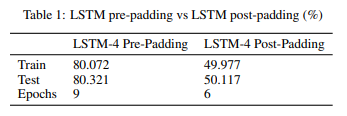

또, CNN의 경우 pre-padding이나 post-padding의 성능이 유사했는데, 이는 시퀀스 모델링과는 상관없는 CNN의 특성을 반영하였다고 한다. 

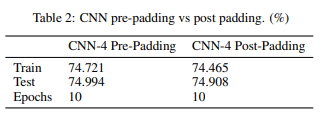

논문의 신뢰성이 조금은 떨어진다는데 다른 논문들도 찾아봐야 겠다는 생각을 했다.

- 당연히 작사를 더 자연스럽게 하려면 단어의 수를 높이면 가능할거라고 생각한다. 다만 '자연스럽다' 라는 의미는 많은 단어를 학습시키는 것도 중요하지만, 매끄러운 문장, 더 수준있는 문장을 만들려면 어떤 부분이 더 중요할까?


- 영어로 작사를 하게하는 노드를 진행하니 한국어로도 진행해보고 싶다는 생각이 들었다. 찾아보면서 언어의 특성이 중요하다 라는 것을 생각하게 되었는데 한국어는 토큰화가 어렵다,, 또 이외에도 많은 어려움이 있는것을 보았지만 도전은 해보고싶다.


### 부족한 개념 알고가자!

- 토큰화 : https://wikidocs.net/21698

- 패딩 : https://wikidocs.net/83544

- 순환 신경망(RNN): https://wikidocs.net/22886

- [NLP 전처리 패딩: pre-padding과 post-padding 비교](https://blog.naver.com/qbxlvnf11/221945962124)


pre-padding일 경우에는 앞단에 0이 채워져 마지막 단어로 제로 패딩이 입력으로 들어가는 일 없이 올바른 시퀀스 모델링이 진행되게 됩니다.

반면, post-padding일 경우에는 뒷단에 0이 채워져 마지막 단어로 제로 패딩이 입력으로 들어갈 수 있습니다.

이는 시퀀스 모델링을 수행하여 뒷단의 입력이 중요한 recurrent model 입장에서 뒤로 갈수록 피처가 희미해지는 long-dependency 현상을 심화시킬 수 있습니다.
